In [ ]:
#Packages needed
# !pip install tensorflow==2.1.0
# !pip install --upgrade pip
# !pip install numpy libtiff
#!pip install tensorflow_addons==0.9.1
# !pip install opencv-python

In [ ]:
#Imports
import tensorflow as tf
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from tensorflow.keras import layers, Model, utils, losses, optimizers
tf.keras.utils.Sequence
from libtiff import TIFF
from scipy.signal import convolve2d
from PIL import Image
import pandas as pd
import tensorflow_addons as tfa
import copy
tf.debugging.set_log_device_placement(True)

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# ELASTIC DEFORMATION ALGORITHM

"""
This function is copied from https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a and it was modified to serve our purposes """

def elastic_transform(image, label, alpha = 190, sigma = 10, random_state=None, margin = 15):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """

    """Takes a list of images as input and returns a list of images as output with the same deformations 
    """
    assert len(image.shape)==2
    if random_state is None:
        random_state = np.random.RandomState(None)
    shape = image.shape
    shapev = tuple(np.subtract(shape, (margin*2, margin*2)))

    dx = gaussian_filter((random_state.rand(*shapev) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shapev) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dx = np.pad(dx, [(margin, margin), (margin, margin)], mode='constant')
    dy = np.pad(dy, [(margin, margin), (margin, margin)], mode='constant')

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    image = map_coordinates(image, indices, order=1).reshape(shape)

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    label = map_coordinates(label, indices, order=1).reshape(shape)

    return image, label

""" Our functions """
def elastic_transform_data(images, labels, alpha = 190, sigma = 10, random_state=None, margin = 15):
    transf_images = np.empty_like(images)
    transf_labels = np.empty_like(labels)
    assert len(images)==len(labels)
    for i in range(len(images)):
        transf_images[i], transf_labels[i] = elastic_transform(images[i], labels[i], alpha, sigma, random_state, margin)
    return transf_images, transf_labels

def add_noise(images, labels, sigma = 0.05):
    noisy_images = np.empty_like(images)
    for i in range(len(images)):
        noise = np.random.normal(0, sigma, images[i].shape)
        noisy_images[i] = images[i] + noise
    return noisy_images, labels
    
def add_borders(images, labels=None, border_size=64):
    if labels == None:           
        border_images = np.empty((images.shape[0], images.shape[1] + border_size*2, images.shape[2] + border_size*2))
        for i in range(len(images)):
            border_images[i] = cv2.copyMakeBorder(images[i], border_size, border_size, border_size, border_size, cv2.BORDER_REFLECT)
        return border_images
    else:
        border_images = np.empty((images.shape[0], images.shape[1] + border_size*2, images.shape[2] + border_size*2))
        border_labels = np.empty((labels.shape[0], labels.shape[1] + border_size*2, labels.shape[2] + border_size*2))
        for i in range(len(images)):
            border_images[i] = cv2.copyMakeBorder(images[i], border_size, border_size, border_size, border_size, cv2.BORDER_REFLECT)
            border_labels[i] = cv2.copyMakeBorder(labels[i], border_size, border_size, border_size, border_size, cv2.BORDER_REFLECT)
        return border_images, border_labels

def split_data(images, labels):
    print('inside split data!')
    a = np.concatenate((images[np.newaxis], labels[np.newaxis]))
    #print(f'a size {a.shape}, image_size {images.shape}')
    s = np.concatenate((a[:, :, 0:640, 0:640],
                        a[:, :, 0:640, 124:],
                        a[:, :, 124:, 0:640],
                        a[:, :, 124:, 124:]), axis=1)  
    #print(f's size {s.shape}')
    del images, labels
    return s[0], s[1]

def crop_labels(labels):
    cropped_lab = []
    for label in labels:
        cropped_lab.append(label[126:514, 126:514])
    cropped_lab = np.array(cropped_lab)
    return cropped_lab

def crop_image(image, dim):
    d = int((image.shape[0] - dim) / 2)
    cropped_im = image[d:(image.shape[0] - d), d:(image.shape[0] - d)]
    return cropped_im

In [ ]:
train_data = TIFF.open('/home/jovyan/work/data/train-volume.tif') # open tiff file in read mode
labels_data = TIFF.open('/home/jovyan/work/data/train-labels.tif')

train_augment = []
labels_augment = []

# read all images in a TIFF file:
train_iter = train_data.iter_images()
labels_iter = labels_data.iter_images()
string = "training"
for data in [train_iter, labels_iter]:
    images_list = None
    nimages = 0
    for image in data:
        # normalize
        im = np.array(image)/255                       
        image_transform = [im, Image.fromarray(im).transpose(Image.FLIP_TOP_BOTTOM)]
        # rotate images
        for angle in [np.pi/2, np.pi, (3/2)*np.pi]: 
            rotated = tfa.image.rotate(im, tf.constant(angle))
            image_rot = np.array(rotated)
            flip_im = Image.fromarray(image_rot).transpose(Image.FLIP_TOP_BOTTOM)
            image_transform.append(image_rot)
            image_transform.append(np.array(flip_im))
        image_transform = np.stack(image_transform)
        # add reflected margins
        image_transform = add_borders(image_transform)
        # add all to training sets
        if images_list is None :
            images_list = image_transform
        else:
            images_list = np.concatenate((images_list, image_transform))
        nimages += 1
    if data == train_iter:
        train_augment = images_list
    else:
        labels_augment = images_list
    print("There are " + str(nimages) + " images in the " + string + " set")
    string = "labels"

del images_list, image_transform, flip_im, im, rotated, 
del train_iter, labels_iter, train_data, labels_data

print("There are " + str(train_augment.shape[0]) + " images in the augmented training set")
print("There are " + str(labels_augment.shape[0]) + " images in the augmented labels set")
print("Size of augmented training images: " + str(train_augment[2].shape) + ".")

print("Size of augmented label images: " + str(labels_augment[2].shape) + ".")

Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cos in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sin in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice

In [ ]:
dropout = True
batchnorm = True
dropout_val = 0.5
run = 6

In [ ]:
def ResBlock(feats_map_in, feats_map_out, data_in):
    if feats_map_in != feats_map_out:
        data_in = layers.Conv2D(feats_map_out, (1, 1), activation='relu', padding='same')(data_in)
    if batchnorm: conv_net = layers.BatchNormalization()(data_in)
    conv_net = layers.Conv2D(feats_map_out, (3, 3), activation = 'relu', padding = 'same')(data_in)
    if batchnorm: conv_net = layers.BatchNormalization()(conv_net)
    conv_net = layers.Conv2D(feats_map_out, (3, 3), activation = 'relu', padding = 'same')(conv_net)
    conv_net = layers.Add()([data_in, conv_net])
    return conv_net

In [ ]:
#FusionNet architecture with CNNs tensorflow keras library
INPUT_SHAPE = (640, 640, 1)  #This shape gives the corresponding shapes given in FusionNet paper
feature_maps = 64

#input - Use Input not InputLayer from Keras 
input_layer = layers.Input((INPUT_SHAPE)) 
#Downsampling - By maxpooling
conv_net1 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'same')(input_layer) #padding = 'same' -> given in paper
if batchnorm: conv_net1 = layers.BatchNormalization()(conv_net1)
res_net1 = ResBlock(feature_maps, feature_maps, conv_net1)
conv_net1 = layers.Conv2D(feature_maps, (3,3), activation = 'relu', padding = 'same')(res_net1)
if batchnorm: conv_net1 = layers.BatchNormalization()(conv_net1)
if dropout: conv_net1 = layers.Dropout(dropout_val) (conv_net1)
max_pool1 = layers.MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same')(conv_net1)


feature_maps *= 2
conv_net2 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'same')(max_pool1)
if batchnorm: conv_net2 = layers.BatchNormalization()(conv_net2)
res_net2 = ResBlock(feature_maps, feature_maps, conv_net2)
conv_net2 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'same')(res_net2)
if batchnorm: conv_net2 = layers.BatchNormalization()(conv_net2)
if dropout: conv_net2 = layers.Dropout(dropout_val) (conv_net2)
max_pool2 = layers.MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same')(conv_net2)

feature_maps *= 2
conv_net3 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'same')(max_pool2)
if batchnorm: conv_net3 = layers.BatchNormalization()(conv_net3)
res_net3 = ResBlock(feature_maps, feature_maps, conv_net3)
conv_net3 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'same')(res_net3)
if batchnorm: conv_net3 = layers.BatchNormalization()(conv_net3)
if dropout: conv_net3 = layers.Dropout(dropout_val) (conv_net3)
max_pool3 = layers.MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same')(conv_net3)

feature_maps *= 2
conv_net4 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'same')(max_pool3)
if batchnorm: conv_net4 = layers.BatchNormalization()(conv_net4)
res_net4 = ResBlock(feature_maps, feature_maps, conv_net4)
conv_net4 = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'same')(res_net4)
if batchnorm: conv_net4 = layers.BatchNormalization()(conv_net4)
if dropout: conv_net4 = layers.Dropout(dropout_val) (conv_net4)
max_pool4 = layers.MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same')(conv_net4)

#Bridge
feature_maps *= 2
conv_net_bn = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'same')(max_pool4)
if batchnorm: conv_net_bn = layers.BatchNormalization()(conv_net_bn)
res_net_bn = ResBlock(feature_maps, feature_maps, conv_net_bn)
if dropout: res_net_bn = layers.Dropout(dropout_val) (res_net_bn)
conv_net_bn = layers.Conv2D(feature_maps, (3, 3), activation = 'relu', padding = 'same')(res_net_bn)
if batchnorm: conv_net_bn = layers.BatchNormalization()(conv_net_bn)

#Upsampling - By Transposed Convolution
feature_maps /= 2
up_sample1 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'same')(conv_net_bn)
if batchnorm: up_sample1 = layers.BatchNormalization()(up_sample1)
up_sample1 = layers.Conv2DTranspose(int(feature_maps), (2, 2), strides = 2, padding = 'same')(up_sample1)
conv_net5 = layers.Add() ([up_sample1, conv_net4])
if dropout: conv_net5 = layers.Dropout(dropout_val) (conv_net5)
res_net5 = ResBlock(int(feature_maps), int(feature_maps), conv_net5)
conv_net5 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'same')(res_net5)
if batchnorm: conv_net5 = layers.BatchNormalization()(conv_net5)

feature_maps /= 2
up_sample2 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'same')(conv_net5)
if batchnorm: up_sample2 = layers.BatchNormalization()(up_sample2)
up_sample2 = layers.Conv2DTranspose(int(feature_maps), (2, 2), strides = 2, padding = 'same')(up_sample2)
conv_net6 = layers.Add()([up_sample2, conv_net3])
if dropout: conv_net6 = layers.Dropout(dropout_val) (conv_net6)
res_net6 = ResBlock(int(feature_maps), int(feature_maps), conv_net6)
conv_net6 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'same')(res_net6)
if batchnorm: conv_net6 = layers.BatchNormalization()(conv_net6)

feature_maps /= 2
up_sample3 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'same')(conv_net6)
if batchnorm: up_sample3 = layers.BatchNormalization()(up_sample3)
up_sample3 = layers.Conv2DTranspose(int(feature_maps), (2, 2), strides = 2, padding = 'same')(up_sample3)
conv_net7 = layers.Add()([up_sample3, conv_net2])
if dropout: conv_net7 = layers.Dropout(dropout_val) (conv_net7)
res_net7 = ResBlock(int(feature_maps), int(feature_maps), conv_net7)
conv_net7 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'same')(res_net7)
if batchnorm: conv_net7 = layers.BatchNormalization()(conv_net7)

feature_maps /= 2
up_sample4 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'same')(conv_net7)
if batchnorm: up_sample4 = layers.BatchNormalization()(up_sample4)
up_sample4 = layers.Conv2DTranspose(int(feature_maps), (2, 2), strides = 2, padding = 'same')(up_sample4)
conv_net8 = layers.Add()([up_sample4, conv_net1])
if dropout: conv_net8 = layers.Dropout(dropout_val) (conv_net8)
res_net8 = ResBlock(int(feature_maps), int(feature_maps), conv_net8)
conv_net8 = layers.Conv2D(int(feature_maps), (3, 3), activation = 'relu', padding = 'same')(res_net8)
if batchnorm: conv_net8 = layers.BatchNormalization()(conv_net8)

#output
conv_net_out = layers.Conv2D(1, (1, 1), activation='sigmoid', padding = 'same')(conv_net8)

fusionnet_model = Model(input_layer, conv_net_out)
fusionnet_model.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

(240, 640, 640)
(240, 640, 640)


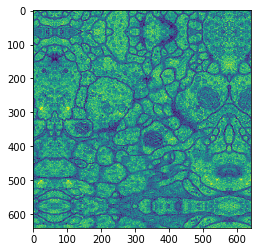

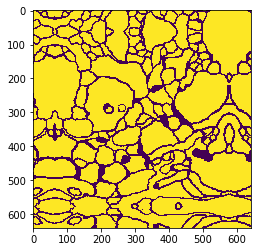

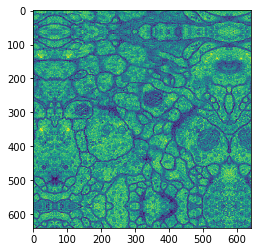

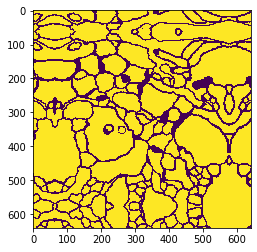

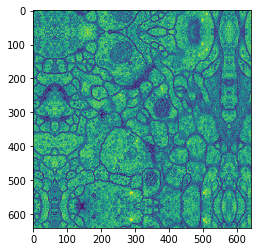

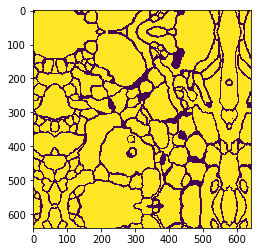

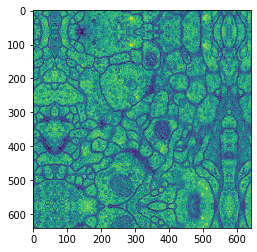

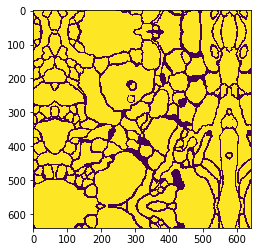

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, train_augment, labels_augment):
        self.train = train_augment
        self.labels = labels_augment
        self.flag = False
    
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        self.flag = True

    def __len__(self):
        return math.ceil(len(self.train))

    def __getitem__(self, idx):
        t = copy.deepcopy(self.train[idx:idx+1])
        l = copy.deepcopy(self.labels[idx:idx+1])
        if self.flag:
            x, y = elastic_transform_data(t, l)
            # x, y = add_noise(x, y)
        else:
            y = l
            x = t
        return np.expand_dims(x, axis=-1), np.expand_dims(y, axis=-1)

print(train_augment.shape)
print(labels_augment.shape)

train_datagen = DataGenerator(train_augment, labels_augment)

for i in range(8, 12):
    pl = np.squeeze(train_datagen[i][0][0])
    lo = np.squeeze(train_datagen[i][1][0])
    plt.figure()
    plt.imshow(pl)
    plt.figure()
    plt.imshow(lo)

In [ ]:
#Data

test_data = TIFF.open('/home/jovyan/work/data/test-volume.tif')
test_iter = test_data.iter_images()
test_images = []
for t_data in test_iter:
    test_im = t_data/255
    test_images.append(test_im)

print(len(test_images))

test_images_predcit = []
for im_test in test_images:
    test_images_predcit.append(np.array(im_test)) 

test_images_array = np.array(test_images_predcit)


print(test_images_array.shape)

test_images_padded = add_borders(test_images_array)

print(test_images_padded.shape)

30
(30, 512, 512)
(30, 640, 640)


In [0]:
print(train_augment.shape)
print(labels_augment.shape)

train_datagen = DataGenerator(train_augment, labels_augment)

fusionnet_model.compile(optimizer = 'adam',                         #optimizers.SGD(learning_rate=0.01, momentum=0.99)
                    loss = 'binary_crossentropy',
                     metrics=['accuracy'])
print('Fit model on training data and validation data : ')
#Need train data as well as labels to train!

fusionnet_callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor='accuracy',min_delta=1e-2,patience=2,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='/home/jovyan/work/checkpoints/fusionnet_100_do_0_5.hdf5',
                                        save_best_only=True, monitor='accuracy',
                                        verbose=1)
]

with tf.device('/GPU:0'):
    fusionnet_model_history = fusionnet_model.fit(train_datagen, epochs = 200, callbacks=fusionnet_callbacks)


(240, 640, 640)
(240, 640, 640)
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Fit model on training data and validation data : 
  ...
    to  
  ['...']
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Train for 240 steps
Epoch 1/200
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp

239/240 [============================>.] - ETA: 0s - loss: 0.1291 - accuracy: 0.9432
Epoch 00039: accuracy improved from 0.94291 to 0.94325, saving model to /home/jovyan/work/checkpoints/fusionnet_100_do_0_5.hdf5
240/240 [==============================] - 174s 726ms/step - loss: 0.1290 - accuracy: 0.9432
Epoch 40/200
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
239/240 [============================>.] - ETA: 0s - loss: 0.1270 - accuracy: 0.9441
Epoch 00040: accuracy improved from 0.94325 to 0.94409, saving model to /home/jovyan/work/checkpoints/fusionnet_100_do_0_5.hdf5
240/240 [==============================] - 176s 732ms/step - loss: 0.1270 - accuracy: 0.9441
Epoch 41/200
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
239/240 [=======================

In [ ]:
print('\nhistory dict:', fusionnet_model_history.history) 


history dict: {'loss': [0.283023938164115, 0.2038285916050275, 0.19120480616887411, 0.18442537126441796, 0.18168065162996452, 0.17940778161088625, 0.17656989494959513, 0.17423577619095643, 0.17151006497442722, 0.17016414664685725, 0.1677110061670343, 0.16630367829153936, 0.16251189882556596, 0.160181568749249, 0.15880492720752953, 0.1580843035131693, 0.1554762592539191, 0.15553083283205826, 0.15412321637074153, 0.15017250900467236, 0.14995868684103092, 0.14722037197401125, 0.14738878238325318, 0.14408937692642212, 0.14196124983330569, 0.1408189413137734, 0.1404823871018986, 0.13854196810473998, 0.1407548811286688, 0.13690724972014626, 0.1358966904692352, 0.1339808373712003, 0.1330564995917181, 0.13222760719557602, 0.13340114932507277, 0.13276310274377465, 0.12968450635671616, 0.1305951300698022, 0.12903918068235118, 0.1270259814336896, 0.12502871320272485, 0.12484083079422513, 0.1242283479621013, 0.12367585112030308, 0.12221883979315559, 0.12088499274104833, 0.12105985954403878, 0.120

In [ ]:
metrics = fusionnet_model_history.history.keys() 
print(metrics)

dict_keys(['loss', 'accuracy'])


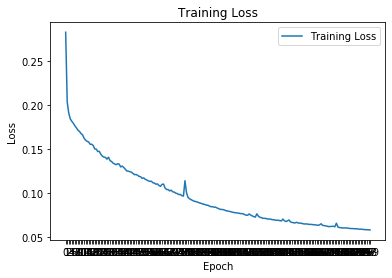

In [ ]:
metrics = fusionnet_model_history.history.keys() 
plt.plot(fusionnet_model_history.history['loss'], label='Training Loss')
# plt.plot(fusionnet_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 200, 1))
# plt.ylim([0, 1])
plt.legend()
plt.show()
# plt.savefig('/home/jovyan/work/results/loss_run_' + str(run) + '.png')


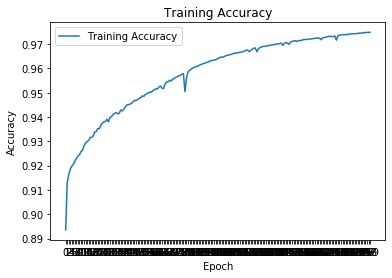

In [ ]:
plt.plot(fusionnet_model_history.history['accuracy'], label='Training Accuracy')
# plt.plot(fusionnet_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 200, 1))
plt.legend()
plt.show()
# plt.savefig('/home/jovyan/work/results/accuracy_run' + str(run) +'.png')

In [ ]:
# Evaluate the model on the test data using `evaluate`

test_images_padded = np.expand_dims(test_images_padded, axis=3)
print('\n# Evaluate on test data')
prediction = fusionnet_model.predict(test_images_padded, batch_size=1)
print(prediction) 


# Evaluate on test data
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_326939 in device /job

0.9991964518229166


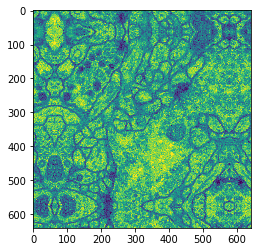

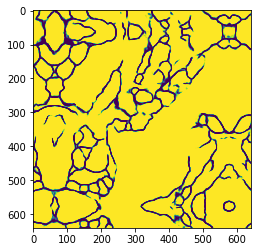

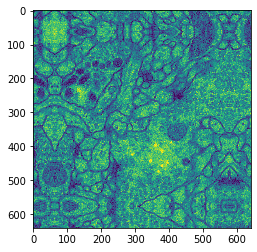

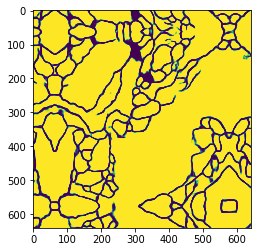

In [ ]:
ex = 30
iou_scores = []
for x in range(ex):
    test_image_1 = test_images_padded[x][:,:,0]

    predicted_image_1 = prediction[x][:,:,0]

    #IOU score
    intersection = np.logical_and(test_image_1, predicted_image_1)
    union = np.logical_or(test_image_1, predicted_image_1)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)
    # print(iou_score)
print(np.mean(iou_scores))

for index in range(2):
    test_image = test_images_padded[index][:,:,0]
    plt.imshow(test_image)
    plt.show()
    # plt.savefig('/home/jovyan/work/results/test_img_run' + str(run) + '_' + str(index) + '.png')

    predicted_image = prediction[index][:,:,0]
    plt.imshow(predicted_image)
    plt.show()
    # plt.savefig('/home/jovyan/work/results/predict_img_run' + str(run) + '_' + str(index) + '.png')

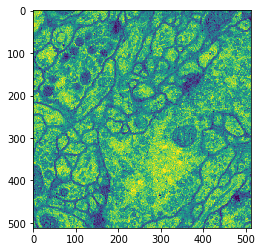

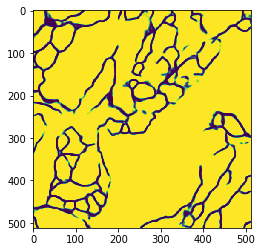

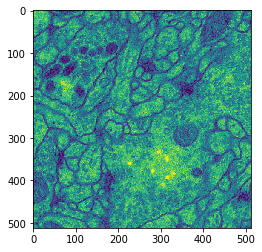

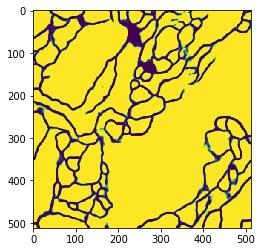

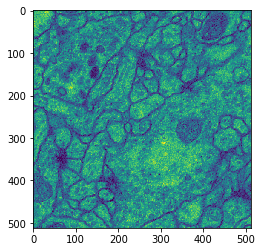

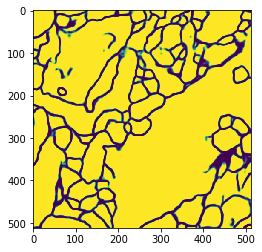

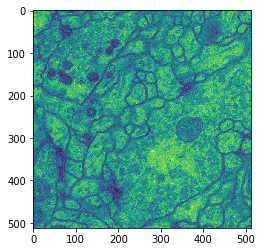

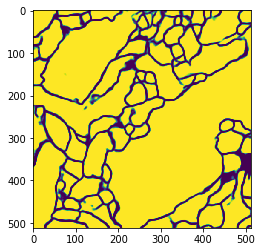

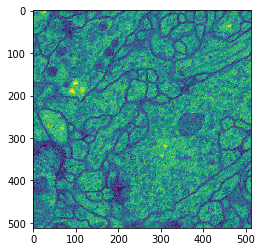

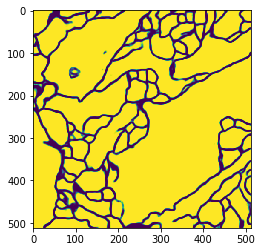

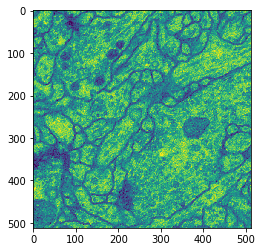

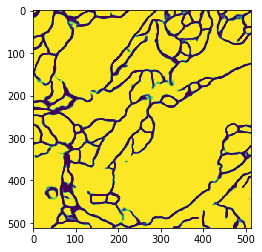

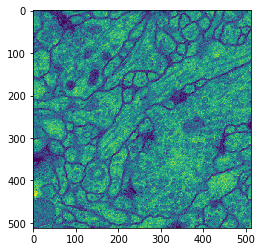

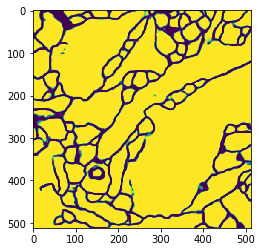

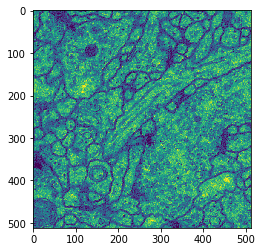

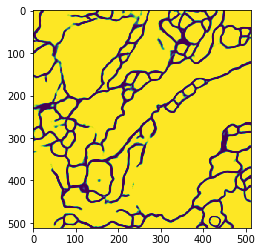

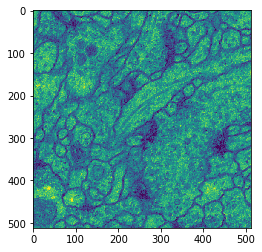

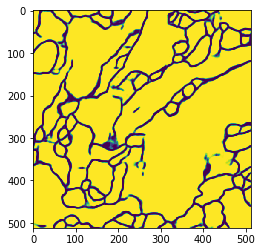

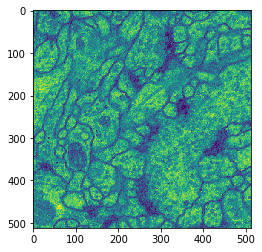

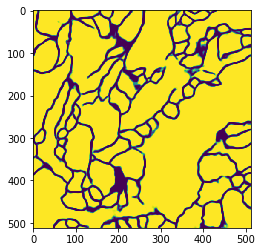

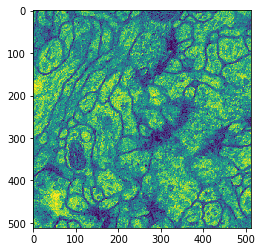

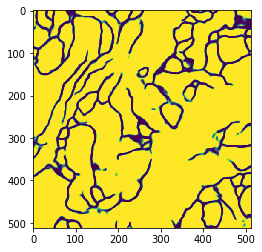

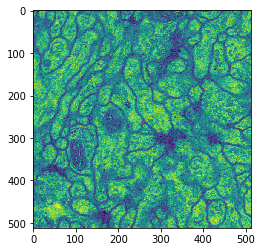

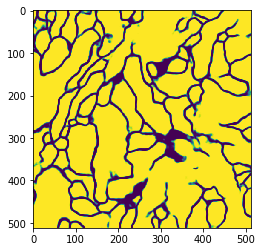

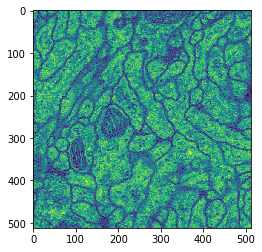

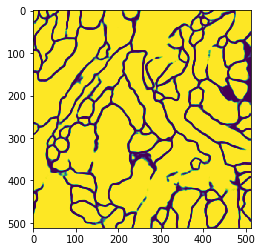

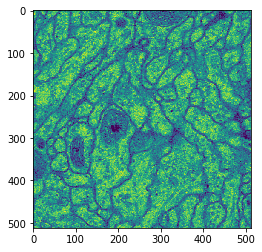

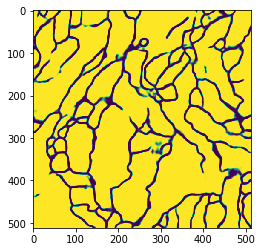

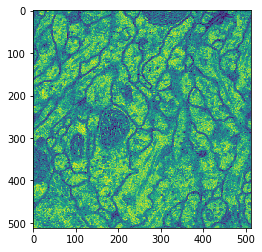

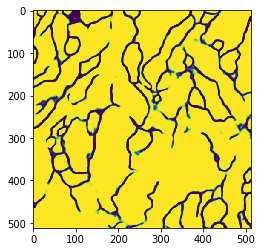

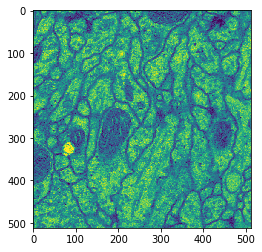

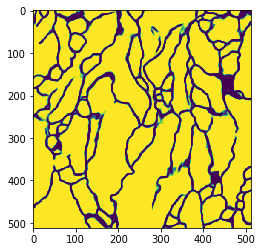

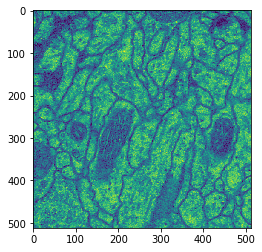

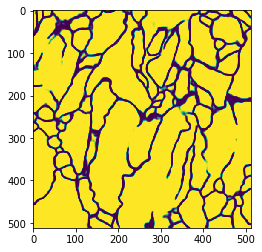

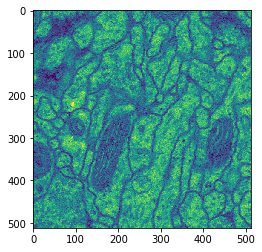

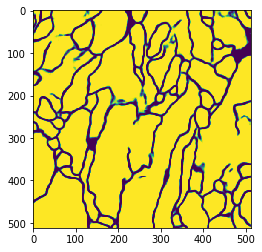

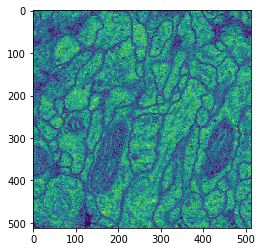

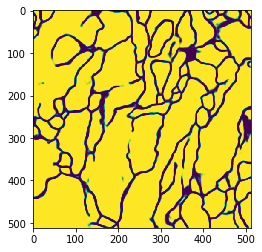

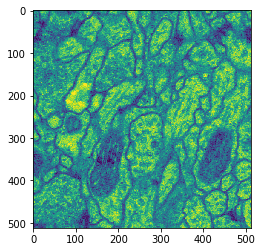

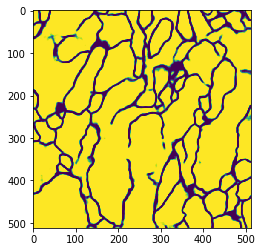

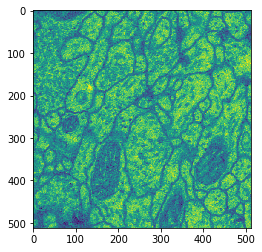

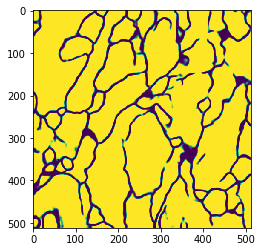

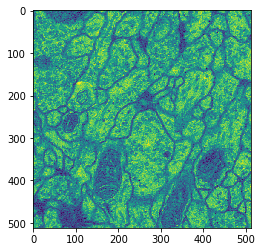

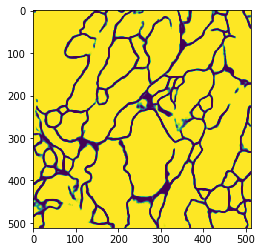

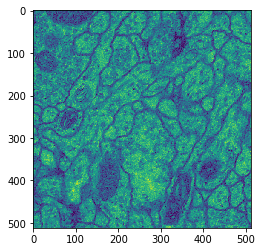

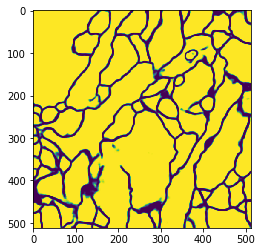

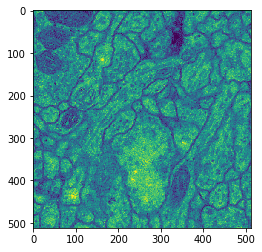

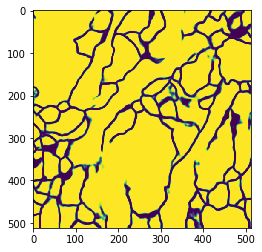

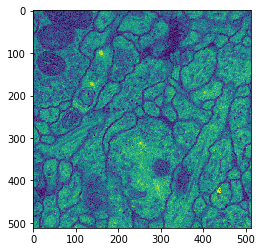

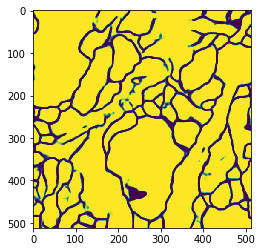

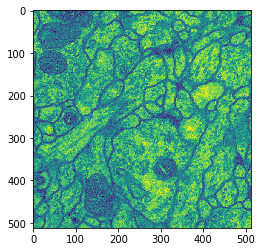

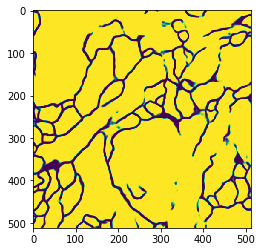

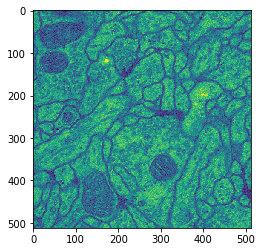

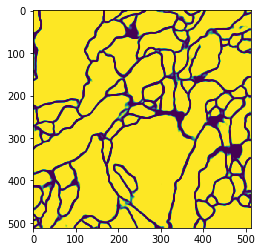

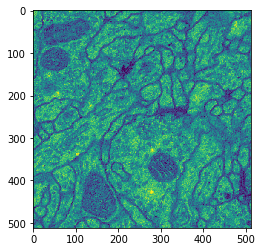

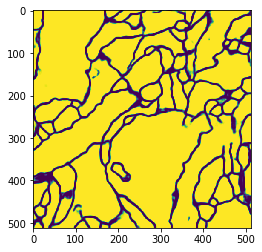

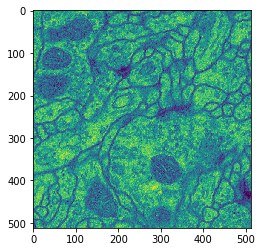

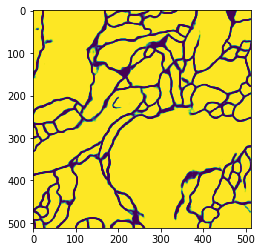

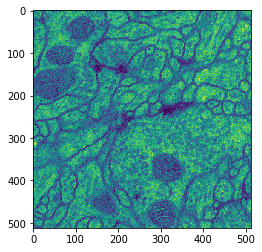

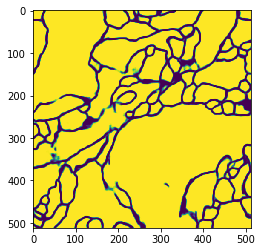

Shape of images in written tiff file: (512, 512)
Number of images in written tiff file: 30


In [ ]:
tif = TIFF.open('/home/jovyan/work/data/predictions.tif', mode='w')
# to write a image to tiff file

for index in range(30):
    test_image = test_images_padded[index][:,:,0]
    test_image = crop_image(test_image, 512)
    plt.imshow(test_image)
    plt.show()
    # plt.savefig('/home/jovyan/work/results/test_img_run' + str(run) + '_' + str(index) + '.png')

    predicted_image = prediction[index][:,:,0]
    predicted_image = crop_image(predicted_image, 512)
    tif.write_image(predicted_image)
    plt.imshow(predicted_image)
    plt.show()
    # plt.savefig('/home/jovyan/work/results/predict_img_run' + str(run) + '_' + str(index) + '.png')


alttiff = TIFF.open('/home/jovyan/work/data/predictions.tif')
count = 0
for image in alttiff.iter_images():
    count = count + 1

print("Shape of images in written tiff file: " + str(image.shape))
print("Number of images in written tiff file: " + str(count))